In [2]:
import os
import rasterio
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import tensorflow as tf

from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import Model
from tensorflow.python.keras.models import Input
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

from keras.utils import normalize

In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [3]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:

# Resolve TPU address
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  

# Connect to the TPU handle and initialize it
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Define the strategy
strategy = tf.distribute.experimental.TPUStrategy(tpu)


<font size=5>Show images</font>

In [7]:
# raster_path = "/kaggle/input/images-soil-erosion/images/image_0_0.jp2"
# with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
#     raster_img = src.read()
#     raster_meta = src.meta

In [8]:
# plt.figure(figsize=(15,15))
# plt.imshow(raster_img[0],  cmap='gray')

In [9]:
# raster_path = "/kaggle/input/patches-images-split/mask_0_0.jp2"
# with rasterio.open(raster_path, "r", driver="JP2OpenJPEG") as src:
#     raster_img = src.read()
#     raster_meta = src.meta

In [10]:
# plt.figure(figsize=(15,15))
# plt.imshow(raster_img[0],  cmap='gray')

<font size=5>Capture images and masks info as a list</font

In [17]:
image_directory = '/kaggle/input/images-soil-erosion/images/'
mask_directory = '/kaggle/input/masks-soil-erosion/masks/'

In [18]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [19]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jp2'):
#         print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, cv2.IMREAD_COLOR)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))


In [20]:
# images = os.listdir(image_directory)
# for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
#     if (image_name.split('.')[1] == 'jp2'):
# #         print(image_directory+image_name)
#         image = cv2.imread(image_directory+image_name, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#         image_dataset.append(image)


In [21]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
#     print(i)
    if (image_name.split('.')[1] == 'jp2'):
        mask = cv2.imread(mask_directory+image_name, 0)
#         print(mask_directory+image_name)
        mask = Image.fromarray(mask)
        mask = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))


In [25]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [27]:
len(image_dataset)

1849

In [28]:
image_dataset = np.squeeze(image_dataset, axis=3)
# mask_dataset = np.squeeze(mask_dataset, axis=3)
print(image_dataset.shape, mask_dataset.shape)

(1849, 256, 256, 3) (1849, 256, 256, 1, 3)


In [2]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

NameError: name 'train_test_split' is not defined

In [15]:
# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
# instantiating the model in the strategy scope creates the model on the TPU
with strategy.scope():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet') # classes=2, activation='softmax'
    model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
#     class_weights = [0.1, 0.9] # higher weight for underrepresented class
#     loss = DiceLoss(class_weights=class_weights)
#     metrics = [IoU(threshold=0.5)]
#     model.compile(optimizer='adam', loss=loss, metrics=[sm.metrics.iou_score])
#     model.summary()

#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [23]:
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
# # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score],)

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    # tried different number of epochs (10-100), 10 for reduce expectation
                    epochs=10, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)


In [ ]:
model.save('/kaggle/working/soil-erosion.h5')

In [ ]:
#Evaluate the model

In [ ]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import random

In [ ]:
test_img_number = 179#random.randint(0, len(X_test))
# print(test_img_number)
test_img = X_test[test_img_number]
plt.imshow(test_img, cmap='gray')

test_img = test_img.astype('uint8')
test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
# plt.imshow(test_img, cmap='gray')
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)[0,:,:,0] > 0.05


In [ ]:
plt.imshow(y_train[test_img_number], cmap='gray')

In [ ]:
# # Resize the image to (256, 256)
# resized_img = cv2.resize(mask1, (256, 256))

# # Convert the image to grayscale
# # gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
prediction[prediction < 0.5] = 0
prediction[prediction > 0.5] = 1

prediction_image = prediction.reshape((256, 256))
plt.imshow(prediction_image)

1/1 [==============================] - 1s 722ms/step


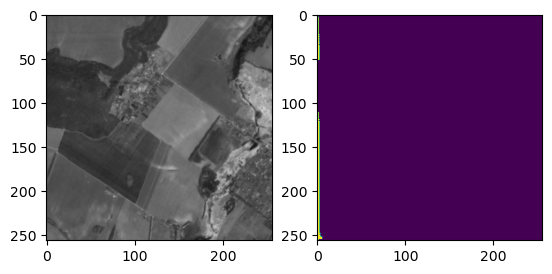

In [56]:
test_img = cv2.imread('/kaggle/input/images-soil-erosion/images/image_0_0.jp2', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (IMG_HEIGHT, IMG_WIDTH))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

test_img1 = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img1)[0]

#View and Save segmented image
prediction_image = prediction.reshape(256, 256)
# plt.imshow(prediction_image, cmap='gray')
# plt.imsave('membrane/test0_segmented.jpg', prediction_image, cmap='gray')

fig, ax = plt.subplots(1, 2)
ax[0].imshow(test_img)
ax[1].imshow(prediction_image)
plt.show()

In [15]:
# X = raster_images
# Y = mask_images
# Y = np.expand_dims(Y, axis=3)

In [15]:
# X = raster_images
# Y = mask_images
# Y = np.expand_dims(Y, axis=3)

In [15]:
# X = raster_images
# Y = mask_images
# Y = np.expand_dims(Y, axis=3)

In [17]:
# X = X / 255.0
# Y = Y / 255.0

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=123)

In [20]:
# model = unet((256, 256, 3))

In [26]:
# # instantiating the model in the strategy scope creates the model on the TPU
# with strategy.scope():
#     model = unet((256, 256, 3))
# #     model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [27]:
model_path = "/kaggle/working/unet.h5"

In [28]:
# checkpoint = ModelCheckpoint(model_path,
#                              monitor="val_loss",
#                              mode="min",
#                              verbose=1)

In [29]:
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [40]:
# test_img = cv2.imread('/kaggle/input/patches-images-split/image_0_0.jp2', cv2.IMREAD_COLOR)       
# test_img = cv2.resize(test_img, (256, 256))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# # plt.imshow(test_img, cmap='gray')
# test_img = np.expand_dims(test_img, axis=0)

In [41]:
# prediction = model.predict(test_img)

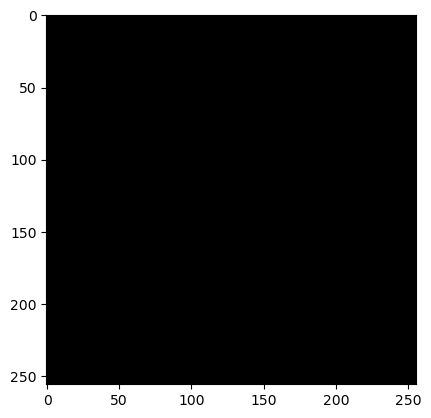

In [42]:
# prediction_image = prediction.reshape(mask_img.shape)
# plt.imshow(prediction_image, cmap='gray')
# # plt.imsave('/kaggle/working/test0_segmented.jpg', prediction_image, cmap='gray')

In [ ]:
# import numpy as np
# from keras.preprocessing.image import ImageDataGenerator

# # Set the input shape of the model
# input_shape = (256, 256)

# # Define the data generator for the images
# image_datagen = ImageDataGenerator(rescale=1./255)

# # Define the data generator for the masks
# mask_datagen = ImageDataGenerator()

# # Set the batch size and the number of classes
# batch_size = 32
# num_classes = 1

# # Define the image and mask generators
# image_generator = image_datagen.flow_from_directory(
#     raster_images,
#     target_size=input_shape,
#     batch_size=batch_size,
#     class_mode=None,
#     shuffle=False,
#     seed=1
# )

# mask_generator = mask_datagen.flow_from_directory(
#     mask_images,
#     target_size=input_shape,
#     batch_size=batch_size,
#     color_mode='grayscale',
#     class_mode=None,
#     shuffle=False,
#     seed=1
# )

# # Combine the generators into one
# train_generator = zip(image_generator, mask_generator)

